In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [8]:
# Load your dataset with a 'Date' and 'Close' column
# Replace 'your_dataset.csv' with your dataset file
data = pd.read_csv('GOOG.csv')
data['Date'] = pd.to_datetime(data['date'])
data.set_index('Date', inplace=True)

In [9]:
data

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
Date,,,,,,,,,,,,,,
2016-06-14 00:00:00+00:00,GOOG,2016-06-14 00:00:00+00:00,718.27,722.470,713.1200,716.48,1306065,718.27,722.470,713.1200,716.48,1306065,0.0,1.0
2016-06-15 00:00:00+00:00,GOOG,2016-06-15 00:00:00+00:00,718.92,722.980,717.3100,719.00,1214517,718.92,722.980,717.3100,719.00,1214517,0.0,1.0
2016-06-16 00:00:00+00:00,GOOG,2016-06-16 00:00:00+00:00,710.36,716.650,703.2600,714.91,1982471,710.36,716.650,703.2600,714.91,1982471,0.0,1.0
2016-06-17 00:00:00+00:00,GOOG,2016-06-17 00:00:00+00:00,691.72,708.820,688.4515,708.65,3402357,691.72,708.820,688.4515,708.65,3402357,0.0,1.0
2016-06-20 00:00:00+00:00,GOOG,2016-06-20 00:00:00+00:00,693.71,702.480,693.4100,698.77,2082538,693.71,702.480,693.4100,698.77,2082538,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-07 00:00:00+00:00,GOOG,2021-06-07 00:00:00+00:00,2466.09,2468.000,2441.0725,2451.32,1192453,2466.09,2468.000,2441.0725,2451.32,1192453,0.0,1.0
2021-06-08 00:00:00+00:00,GOOG,2021-06-08 00:00:00+00:00,2482.85,2494.495,2468.2400,2479.90,1253253,2482.85,2494.495,2468.2400,2479.90,1253253,0.0,1.0
2021-06-09 00:00:00+00:00,GOOG,2021-06-09 00:00:00+00:00,2491.40,2505.000,2487.3300,2499.50,1006337,2491.40,2505.000,2487.3300,2499.50,1006337,0.0,1.0


In [10]:
# Extract the 'Close' prices and normalize the data
scaler = MinMaxScaler()
data['close'] = scaler.fit_transform(data['close'].values.reshape(-1, 1))


In [22]:
# Define a function to prepare the data for LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [23]:
# Split the data into training and testing sets
train_size = int(len(data) * 0.7)
test_size = len(data) - train_size
train_data, test_data = data.iloc[0:train_size], data.iloc[train_size:len(data)]


In [24]:
# Convert the data to numpy arrays
train_data = train_data['close'].values.reshape(-1, 1)
test_data = test_data['close'].values.reshape(-1, 1)

# Set the look-back period (number of previous time steps to consider)
look_back = 30


In [25]:
# Prepare the training and testing datasets
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

# Reshape the data to be 3-dimensional (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [26]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [27]:
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=64)

# Make predictions on the test data
predictions = model.predict(X_test)

Epoch 1/100
14/14 [==============================] - 6s 38ms/step - loss: 0.0092
Epoch 2/100
14/14 [==============================] - 1s 36ms/step - loss: 0.0017
Epoch 3/100
14/14 [==============================] - 1s 37ms/step - loss: 7.1198e-04
Epoch 4/100
14/14 [==============================] - 0s 34ms/step - loss: 3.7739e-04
Epoch 5/100
14/14 [==============================] - 0s 35ms/step - loss: 3.3322e-04
Epoch 6/100
14/14 [==============================] - 1s 42ms/step - loss: 3.1486e-04
Epoch 7/100
14/14 [==============================] - 0s 34ms/step - loss: 3.1164e-04
Epoch 8/100
14/14 [==============================] - 1s 37ms/step - loss: 3.0314e-04
Epoch 9/100
14/14 [==============================] - 0s 34ms/step - loss: 3.0472e-04
Epoch 10/100
14/14 [==============================] - 1s 38ms/step - loss: 3.0203e-04
Epoch 11/100
14/14 [==============================] - 1s 39ms/step - loss: 2.8807e-04
Epoch 12/100
14/14 [==============================] - 1s 45ms/step - lo

14/14 [==============================] - 1s 43ms/step - loss: 1.5440e-04
Epoch 97/100
14/14 [==============================] - 1s 45ms/step - loss: 1.5755e-04
Epoch 98/100
14/14 [==============================] - 1s 39ms/step - loss: 1.5269e-04
Epoch 99/100
14/14 [==============================] - 1s 49ms/step - loss: 1.5486e-04
Epoch 100/100
11/11 [==============================] - 1s 13ms/step


In [28]:
# Inverse transform the predictions and actual values to original scale
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# A lower MAPE value suggests that your predictive model is performing well and has good accuracy.

In [29]:
print(f'Mean Absolute Percentage Error (MAPE): {mean_absolute_percentage_error(y_test,predictions)}')

Mean Absolute Percentage Error (MAPE): 0.03197057581755713


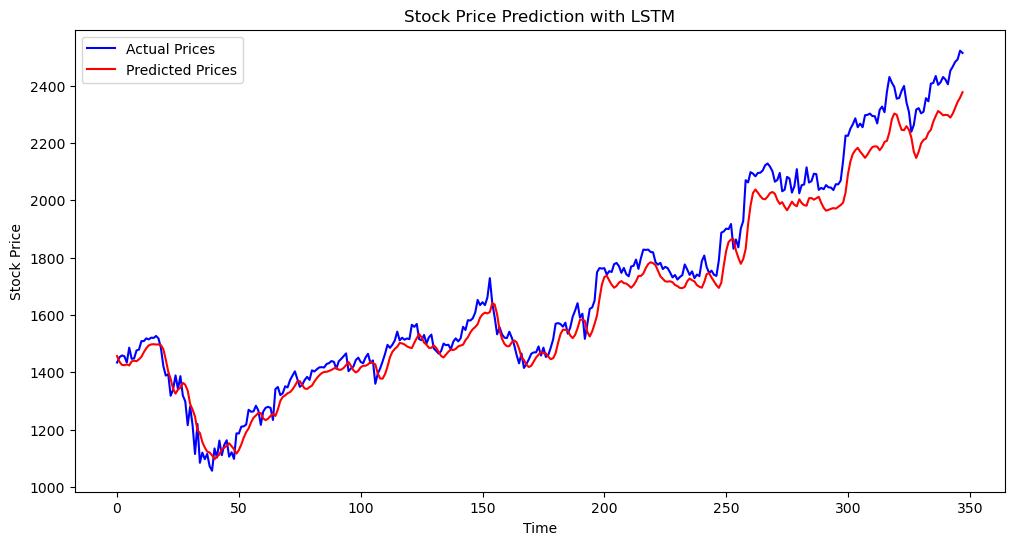

In [21]:
# Plot the actual vs. predicted stock prices
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Prices', color='blue')
plt.plot(predictions, label='Predicted Prices', color='red')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction with LSTM')
plt.legend()
plt.show()